### load predictions from log

In [48]:
# plotting configuration
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

params = {
   'axes.labelsize': 12,
   'text.fontsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
mpl.rcParams.update(params)
sns.set_style("whitegrid")
sns.despine()




/home/roseyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [53]:
#06-15-17-17-24-40
#05-17-17-16-17-44
#06-15-17-17-24-40
time_stamp ="08-22-17-00-24-10"
exp='traffic_uci'
models =["basic_rnn","basic_lstm","matrix_rnn","tensor_rnn"]
hz_list= [32, 64, 128, 256]
lr_list =[1,2,3,4]

import numpy as np
def read_config(fstream):
    d = {}
    for line in fstream:
        line.rstrip()
        tokens = line.split('\t')
        for token in tokens:
            try:
                key, val = token.split(":")
                d[key] = float(val)                
            except ValueError:
                'error prop'
    return d
def load_log(hz, lr, model):
    data_path = "/var/tmp/tensorRNN/log/"+exp+"/"+time_stamp+"/hz_"+str(hz)+"/"+"lr_1e-"+str(lr)+"/"+model+"/"
    f_pred= "predict.npy"
    f_err = "config_error.out"
    pred =  np.load(data_path+f_pred )
    with open(data_path+"/"+f_err,'r') as fstream:
        config = read_config(fstream)
    return config, pred

def reshape_pred(y):
    y = np.squeeze(y)
    n_dim = np.shape(y)[-1]
    y = np.reshape(y, [-1, n_dim])
#     print('y shape', np.shape(y))
    return y

def get_best_pred(model):
    err_best = 1e6
    i=0
    for hz in hz_list:
        j=0
        for lr in lr_list:
#             print('load model {:s}, hidden size {:d}, learning rate 1e-{:d}'.format(model, hz, lr))
            config, pred = load_log(hz, lr, model)
#             print('train error:',config['train_error'],'valid error:',config['valid_error'],'test err:',config['test_error'])
            err =  config['test_error']
            # save the best results so far
            if err < err_best:
                err_best = err
                pred_best = pred     
            j+=1
        i+=1
    y_true, y_pred = pred_best
    y_true = reshape_pred(y_true)
    y_pred = reshape_pred(y_pred)
    return (y_true, y_pred)



pred_rnn = get_best_pred('basic_rnn')
pred_lstm = get_best_pred('basic_lstm')
pred_mrnn = get_best_pred('matrix_rnn')
pred_trnn = get_best_pred('tensor_rnn')


### visualize the time series prediction

/home/roseyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


y true shape (24, 1, 20, 30) y_pred shape (24, 1, 20, 30)
y shape (480, 30)
y shape (480, 30)


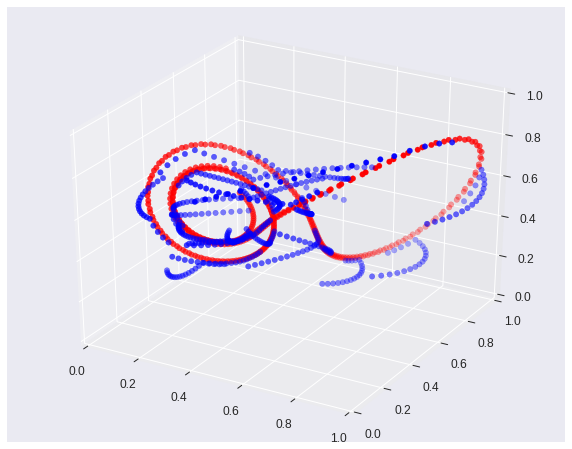

In [68]:
# load the prediction
%matplotlib inline
y_true, y_pred = pred_trnn

print('y true shape', y_true.shape, 'y_pred shape', y_pred.shape)


T= 500
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

# ax.plot(y_true[:T,0], y_true[:T,1], y_true[:T,2], 'r--')
ax.scatter(y_true[:T,0], y_true[:T,1], y_true[:T,2], c='r', s=30)
ax.scatter(y_pred[:T,0], y_pred[:T,1], y_pred[:T,2], c='b', s=30)
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_zlim((0,1))
fig.savefig('lorenz_lt_trnn.png')
# plot_lorenz(y_true,100)

### visualize traffic_uci prediction 

In [32]:
import numpy as np

def nd(y_pred, y_true):
    """normalized deviation"""
    t1 = np.sum(abs(y_pred-y_true))/ np.size(y_true)
    t2 = np.sum(abs(y_true))/np.size(y_true)
    return t1/t2
    
def nrmse(y_pred, y_true):
    """normalized RMSE"""
    t1 = np.linalg.norm(y_pred-y_true)**2 / np.size(y_true)
    t2 = np.sum(abs(y_true))/np.size(y_true)
    return np.sqrt(t1) / (t2)


def eval_forecast(pred):
    y_true, y_pred = pred
#     print('y true shape', y_true.shape, 'y_pred shape', y_pred.shape)


    print('ND', nd(y_pred, y_true))
    print('NRMSE',nrmse(y_pred, y_true))
    return y_true, y_pred

eval_forecast(pred_rnn)
eval_forecast(pred_lstm)
eval_forecast(pred_mrnn)
eval_forecast(pred_trnn)


ND 0.530266786426
NRMSE 0.800489342314
ND 0.418252425517
NRMSE 0.717590472147
ND 0.558732335808
NRMSE 0.854473790875
ND 0.402420109192
NRMSE 0.702850593262


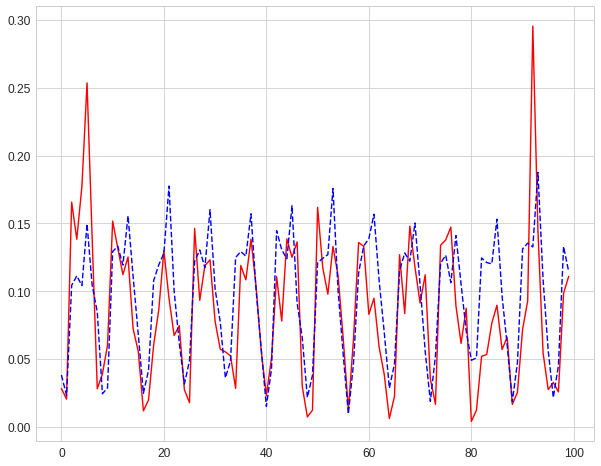

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

y_true, y_pred = pred_trnn
fig = plt.figure(figsize=(10,8))
plt.plot(y_true[0:100,1],'r')
plt.plot(y_pred[0:100,1],'b--')
fig.savefig('traffic_uci_trnn.png')